# Workspace - Challenge 1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
from lumen.io import read_events
from lumen.io import read_positions
from lumen.util import extract_device_events
from lumen.util import plot_devices

from lumen.device import Device
from lumen.model_greed import ModelGreed

## Read data

In [4]:
df_events = read_events('site_1')
df_positions = read_positions('site_1')

In [5]:
events_map = extract_device_events(df_events)
print(f"Number of mapped devices: {len(events_map.keys())}")

Number of mapped devices: 56


In [11]:
device_id_list = sorted(df_events.deviceid.unique())

train_size = int(0.5 * len(device_id_list))
train_device_id_list = np.random.choice(device_id_list, train_size, replace=False)
test_device_id_list = [x for x in device_id_list if x not in train_device_id_list]

len(train_device_id_list), len(test_device_id_list)

(28, 28)

In [15]:
devices_pos = df_positions.set_index('deviceid')

In [16]:
devices = []
real_device_id_to_position_map = {}

for device_id in device_id_list:
    point = devices_pos.loc[device_id]
    position = [point.x, point.y]
    _device = Device(position=position, device_id=None)    
    if device_id in train_device_id_list:
        # Add as known device
        _device.set_device_id(device_id)

    devices.append(_device)
    # To calculate loss
    real_device_id_to_position_map[device_id] = [point.x, point.y]

In [17]:
known_devices = [device for device in devices if device.has_device_id()]
device_id_candidates = set(test_device_id_list)

len(known_devices), len(device_id_candidates)

(28, 28)

In [18]:
model = ModelGreed()
model.fit(df_events)
scored_devices = model.predict(devices, test_device_id_list)

In [19]:
# Calculate loss
loss = 0
for device in scored_devices:
    position = device.position
    real_position = real_device_id_to_position_map.get(device.device_id)
    loss += ((position[0] - real_position[0])**2 + (position[1] - real_position[1])**2)**0.5

loss

10293.122417356772

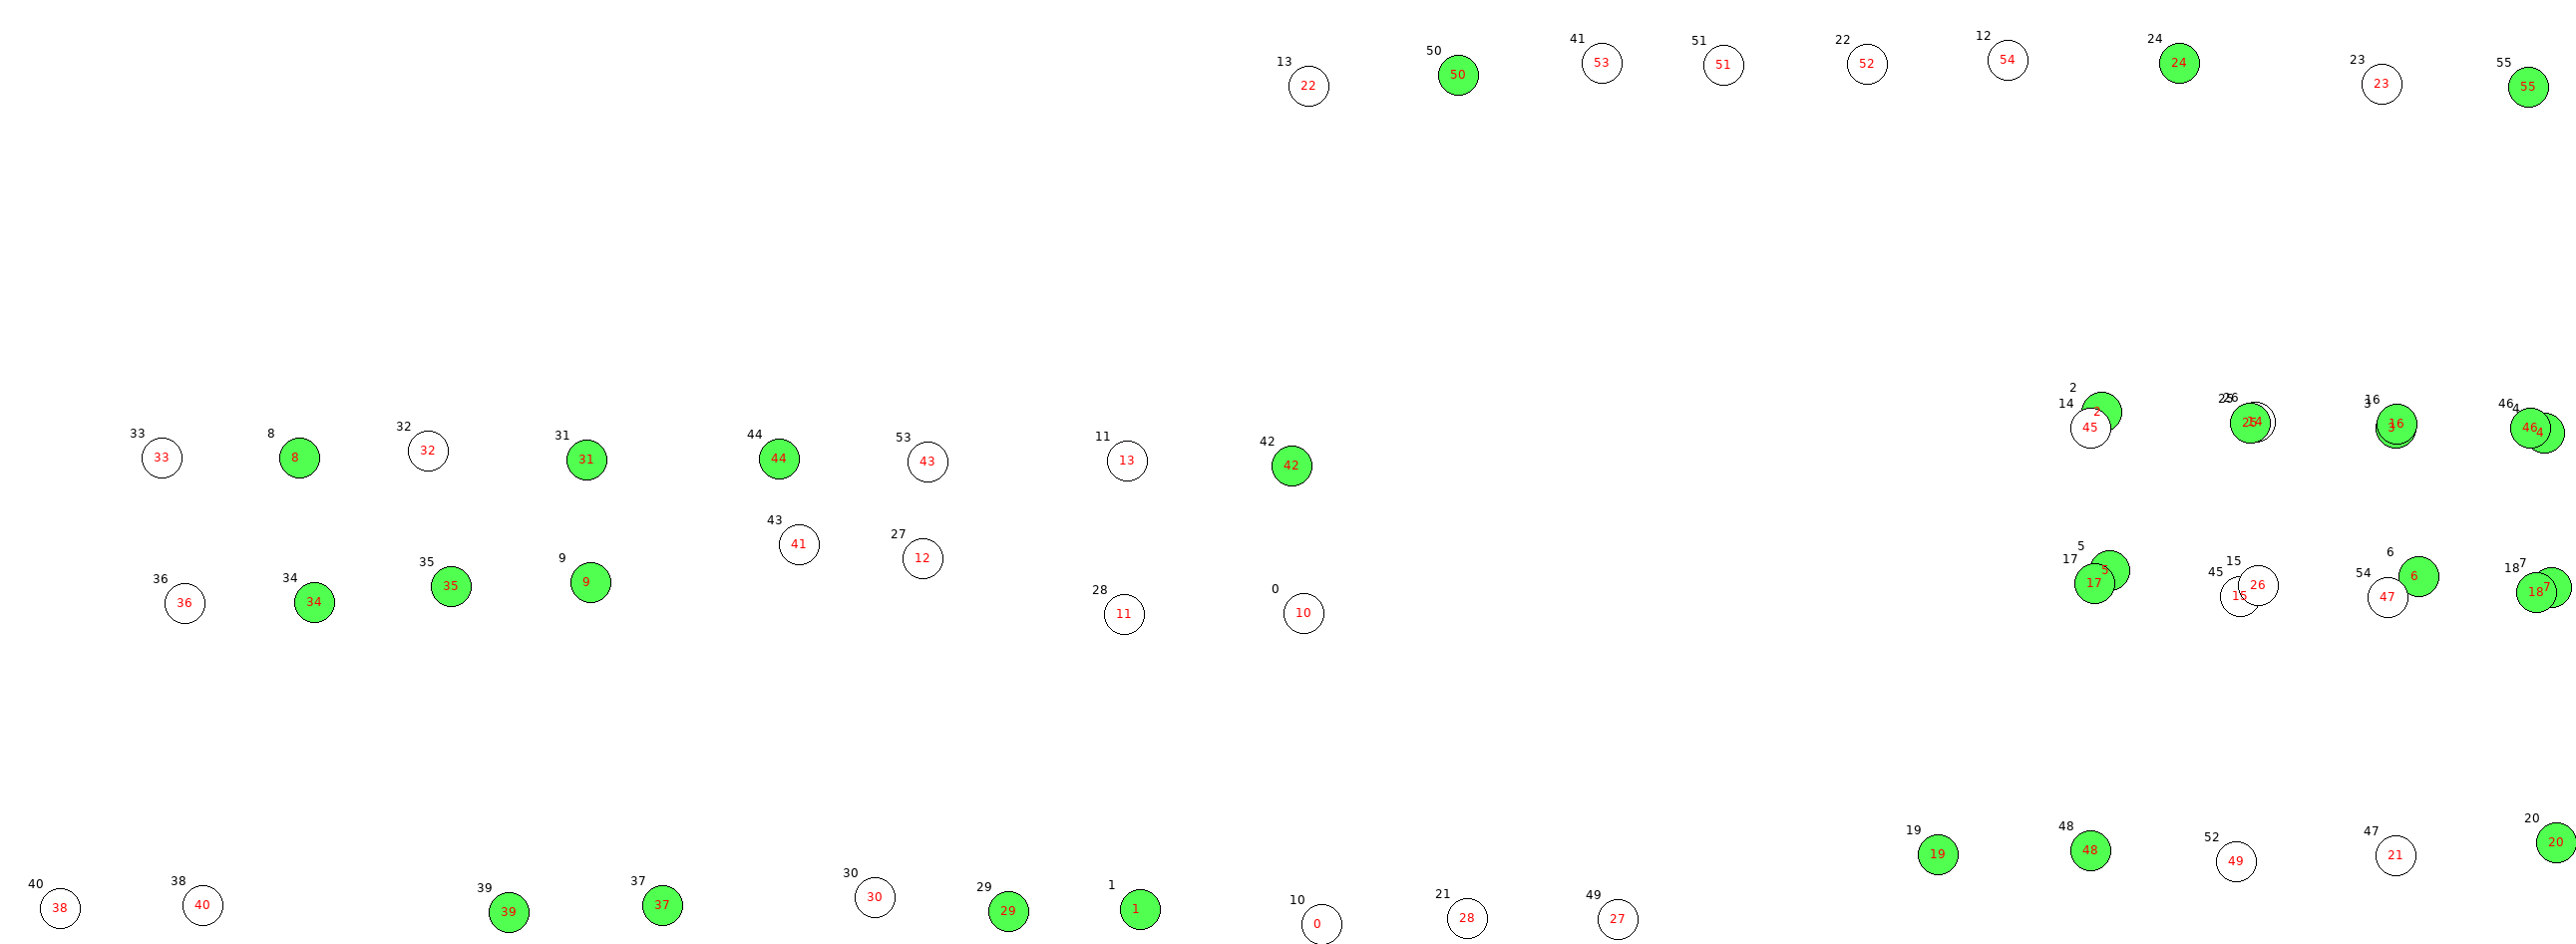

In [20]:
device_id_list = sorted(df_events.deviceid.unique())

plot_devices(scored_devices,
             device_id_list=device_id_list, 
             to_file="model_greed_output.png", 
             text_size=12, 
             radius=40, 
             train_device_id_list=train_device_id_list, 
             real_device_id_to_position_map=real_device_id_to_position_map)

In [22]:
#DEPRECATED
errors = []
splits = [0.1, 0.2, 0.5, 0.7, 0.9]

for split in splits:
    print(f"... estimating loss for split: {split}")
    train_size = int(split * len(device_id_list))
    train_device_id_list = np.random.choice(device_id_list, train_size, replace=False)
    test_device_id_list = [x for x in device_id_list if x not in train_device_id_list]
    
    devices = []
    real_device_id_to_position_map = {}
    for device_id in device_id_list:
        point = devices_pos.loc[device_id]
        position = [point.x, point.y]
        _device = Device(position=position, device_id=None)    
        if device_id in train_device_id_list:
            # Add as known device
            _device.set_device_id(device_id)
        devices.append(_device)
        # To calculate loss
        real_device_id_to_position_map[device_id] = [point.x, point.y]
    
    known_devices = [device for device in devices if device.has_device_id()]
    device_id_candidates = set(test_device_id_list)
    
    model = ModelGreed()
    model.fit(df_events)
    scored_devices = model.predict(devices, test_device_id_list)
    
    # Calculate loss
    loss = 0
    for device in scored_devices:
        position = device.position
        real_position = real_device_id_to_position_map.get(device.device_id)
        loss += ((position[0] - real_position[0])**2 + (position[1] - real_position[1])**2)**0.5

    errors.append(loss)

... estimating loss for split: 0.1
... estimating loss for split: 0.2
... estimating loss for split: 0.5
... estimating loss for split: 0.7
... estimating loss for split: 0.9


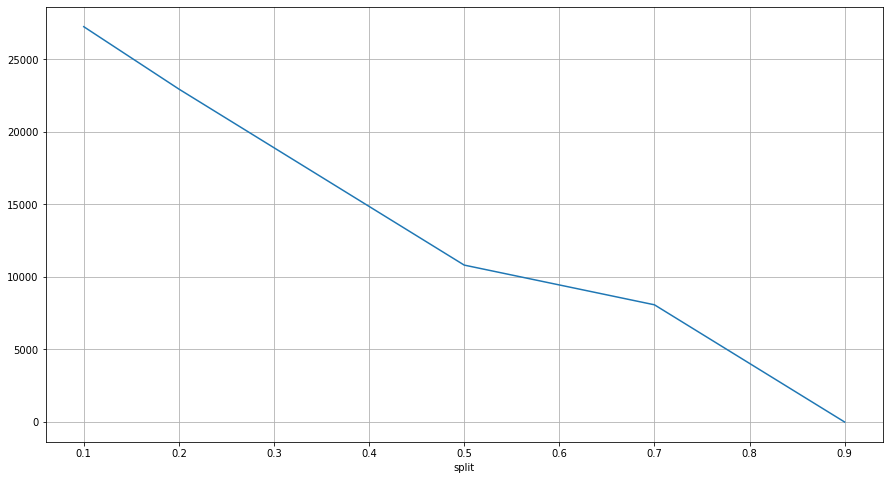

In [ ]:
df = pd.DataFrame()
df['split'] = splits
df['error'] = errors

_ = df.set_index('split').error.plot(figsize=(15, 8), grid=True)

In [ ]:
from datetime import timedelta

split = 0.5
delta_times = [7, 14, 21, 28]

errors = []
days = []

for i in range(10):
    print(f"... run: {i}")

    for delta_time in delta_times:
        time_window_start = df_events.timestamp.min()
        time_window_end = time_window_start + timedelta(days=delta_time)
        sub_df_events = df_events[df_events.timestamp < time_window_end]
        train_size = int(split * len(device_id_list))
        train_device_id_list = np.random.choice(device_id_list, train_size, replace=False)
        test_device_id_list = [x for x in device_id_list if x not in train_device_id_list]
        devices = []
        real_device_id_to_position_map = {}
        for device_id in device_id_list:
            point = devices_pos.loc[device_id]
            position = [point.x, point.y]
            _device = Device(position=position, device_id=None)    
            if device_id in train_device_id_list:
                # Add as known device
                _device.set_device_id(device_id)
            devices.append(_device)
            # To calculate loss
            real_device_id_to_position_map[device_id] = [point.x, point.y]

        known_devices = [device for device in devices if device.has_device_id()]
        device_id_candidates = set(test_device_id_list)

        model = ModelGreed()
        model.fit(sub_df_events)
        scored_devices = model.predict(devices, test_device_id_list)

        # Calculate loss
        loss = 0
        for device in scored_devices:
            position = device.position
            real_position = real_device_id_to_position_map.get(device.device_id)
            loss += ((position[0] - real_position[0])**2 + (position[1] - real_position[1])**2)**0.5

        days.append(delta_time)
        errors.append(loss)

... run: 0


ValueError: Invalid frequency: [Device ID:0 at [3105.5064502509, 1848.2402298074], Device ID:1 at [2923.1398724756, 1833.96304726], Device ID:None at [3887.3458826325, 1334.6310080482], Device ID:3 at [4182.7261872183, 1350.4393679275], Device ID:4 at [4331.192525201, 1355.6760813151], Device ID:5 at [3895.0142949156, 1493.3992194262], Device ID:6 at [4205.1536559049, 1499.382404021], Device ID:7 at [4338.945646574, 1510.8380470545], Device ID:None at [2080.4257499304, 1380.6912041687], Device ID:None at [2372.3778897479, 1505.9710350503], Device ID:None at [3087.7228442104, 1536.6891690568], Device ID:11 at [2907.7078278775, 1537.0699309483], Device ID:None at [2705.7753970699, 1481.4991806382], Device ID:13 at [2910.6063361551, 1383.017043013], Device ID:14 at [4041.7331871628, 1344.2581876378], Device ID:15 at [4026.5392203177, 1519.2627905928], Device ID:None at [4183.6677270568, 1346.8570161011], Device ID:17 at [3880.6501403399, 1506.8059852997], Device ID:None at [4323.1723600771, 1515.6452872039], Device ID:19 at [3723.039866458, 1778.2684947709], Device ID:None at [4343.9756894134, 1766.881110585], Device ID:21 at [4182.7933246773, 1779.9502102105], Device ID:22 at [3092.1701359507, 1007.4092547962], Device ID:23 at [4168.0631130973, 1005.4410038927], Device ID:24 at [3965.4478940825, 984.1595283424], Device ID:None at [4036.6137304075, 1345.2226287623], Device ID:26 at [4044.7010466083, 1508.3475471295], Device ID:None at [3402.0, 1843.0], Device ID:None at [3251.3581246533, 1842.1530648461], Device ID:None at [2791.2399675972, 1835.2002159768], Device ID:None at [2657.9716283903, 1821.6472983517], Device ID:None at [2368.7543560151, 1382.7779365053], Device ID:None at [2209.3054066973, 1373.8198489325], Device ID:None at [1942.0, 1380.0], Device ID:34 at [2095.8081812038, 1525.2690914013], Device ID:35 at [2232.1754723338, 1509.9233162312], Device ID:36 at [1965.1717202607, 1526.012800676], Device ID:37 at [2444.4753049197, 1829.048321257], Device ID:None at [1840.3070357402, 1832.6491962217], Device ID:39 at [2290.7536875252, 1836.3263549399], Device ID:40 at [1983.1786201571, 1829.6576346156], Device ID:None at [2581.2977100297, 1467.2885201921], Device ID:42 at [3075.7684845136, 1388.3967338328], Device ID:None at [2710.9272135755, 1384.162407897], Device ID:None at [2561.3951606268, 1381.0790723245], Device ID:None at [3876.9163400009, 1350.8785656055], Device ID:None at [4317.6860379916, 1350.6546336053], Device ID:None at [4174.9757808072, 1520.278501706], Device ID:48 at [3876.3622575887, 1774.7871903483], Device ID:None at [4022.1419273144, 1785.4242767321], Device ID:None at [3242.4587384119, 996.4176920446], Device ID:None at [3508.7236228305, 986.8464667554], Device ID:52 at [3652.7456493639, 985.5302925457], Device ID:53 at [3386.0811726138, 984.7332994588], Device ID:None at [3793.9415209221, 981.5316404667], Device ID:None at [4315.0, 1008.0]]

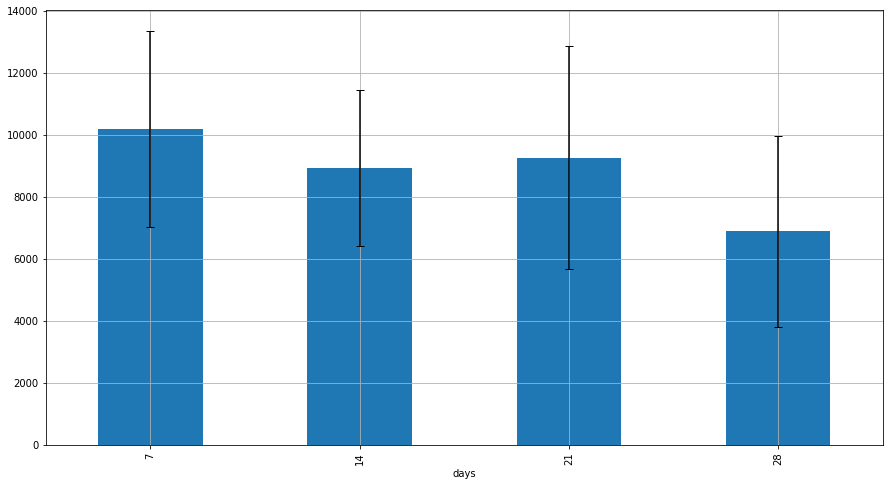

In [ ]:
df = pd.DataFrame()
df['days'] = days
df['error'] = errors
yerr = df.groupby('days').error.std()
_ = df.groupby('days').error.mean().plot.bar(figsize=(15, 8), grid=True, yerr=yerr, capsize=4)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e19bc3ac-22fd-4ca3-9f23-d099570b4b40' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>